In [1]:
import json

import matplotlib.pyplot as plt
import network_diffusion as nd
import networkx as nx
import numpy as np
import pandas as pd

from tqdm import tqdm
from utils import functions, networks

%load_ext autoreload
%autoreload 2

In [2]:
functions.set_seed(42)

In [3]:
out_dir = "icm_mds"

max_epochs = 50
n_runs = 100
patience = 1

protocol = "AND"
probability = 0.5

## ICM on Multilayer Network

In [4]:
aucs = networks.get_aucs_network()
lazega = networks.get_lazega_network()

In [5]:
print(aucs)

network parameters
--------------------------------------------
general parameters:
	number of layers: 5
	number of actors: 61

layer 'facebook' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 32
	number of edges - 124
	average degree - 7.75
	clustering coefficient - 0.5404

layer 'lunch' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 193
	average degree - 6.4333
	clustering coefficient - 0.6733

layer 'coauthor' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 25
	number of edges - 21
	average degree - 1.68
	clustering coefficient - 0.268

layer 'leisure' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 47
	number of edges - 88
	average degree - 3.7447
	clustering coefficient - 0.3925

layer 'work' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 60
	number of edges - 194
	average degree 

In [6]:
print(lazega)

network parameters
--------------------------------------------
general parameters:
	number of layers: 3
	number of actors: 71

layer 'advice' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 71
	number of edges - 556
	average degree - 15.662
	clustering coefficient - 0.376

layer 'friendship' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 71
	number of edges - 725
	average degree - 20.4225
	clustering coefficient - 0.4493

layer 'co-work' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 70
	number of edges - 378
	average degree - 10.8
	clustering coefficient - 0.3908


In [7]:
# propagation prob: 0.1, buget 2% active
def create_mic_model(seeding_budget, seed_selector, protocol, probability):
    return nd.models.MICModel(
        seeding_budget=seeding_budget,
        seed_selector=seed_selector,
        protocol=protocol,
        probability=probability,
    )

In [8]:
model_degree_01 = create_mic_model([95, 5, 0], nd.seeding.DegreeCentralitySelector(), protocol, probability)
model_btw_01 = create_mic_model([95, 5, 0], nd.seeding.BetweennessSelector(), protocol, probability)
model_close_01 = create_mic_model([95, 5, 0], nd.seeding.ClosenessSelector(), protocol, probability)
model_VR_01 = create_mic_model([95, 5, 0], nd.seeding.VoteRankMLNSeedSelector(), protocol, probability)
model_driver_01 = create_mic_model([95, 5, 0], nd.seeding.DriverActorSelector(nd.seeding.DegreeCentralitySelector()), protocol, probability)

model_degree_02 = create_mic_model([90, 10, 0], nd.seeding.DegreeCentralitySelector(), protocol, probability)
model_btw_02 = create_mic_model([90, 10, 0], nd.seeding.BetweennessSelector(), protocol, probability)
model_close_02 = create_mic_model([90, 10, 0], nd.seeding.ClosenessSelector(), protocol, probability)
model_VR_02 = create_mic_model([90, 10, 0], nd.seeding.VoteRankMLNSeedSelector(), protocol, probability)
model_driver_02 = create_mic_model([90, 10, 0], nd.seeding.DriverActorSelector(nd.seeding.DegreeCentralitySelector()), protocol, probability)

In [9]:
models = {
    "degree_05": model_degree_01,
    "degree_10": model_degree_02,
    "btw_05": model_btw_01,
    "btw_10": model_btw_02,
    "close_05": model_close_01,
    "close_10": model_close_02,
    "VR_05": model_VR_01,
    "VR_10": model_VR_02,
    "driver_05": model_driver_01,
    "driver_10": model_driver_02
}

In [10]:
logs_dict = {}

## Lazega

In [11]:
network = lazega
nb_actors = network.get_actors_num()

In [12]:
for model_name, model in models.items():
    print(f"Running experiment for model {model_name}...")

    nb_activated_actors_model = []
    nb_epochs_model = []

    for run in tqdm(range(n_runs)):
        experiment = nd.Simulator(model, network)
        run_logs = experiment.perform_propagation(n_epochs=max_epochs, patience=patience)
        nb_activated_actors_run, nb_epochs_run = functions.convert_micm_logs(run_logs, patience)
        nb_activated_actors_model.append(nb_activated_actors_run)
        nb_epochs_model.append(nb_epochs_run)

    avg_activated_actors_model = np.mean(nb_activated_actors_model)
    avg_epochs_model = np.mean(nb_epochs_model)
    std_activated_actors_model = np.std(nb_activated_actors_model)
    std_epochs_model = np.std(nb_epochs_model)

    print(f"Activated actors: Avg = {avg_activated_actors_model}, Std = {std_activated_actors_model}")
    print(f"Epochs executed: Avg = {avg_epochs_model}, Std = {std_epochs_model}")

    logs_dict[f"logs_lazega_{model_name}"] = (
        100 * avg_activated_actors_model / nb_actors,
        avg_epochs_model,
        100 * std_activated_actors_model / nb_actors,
        std_epochs_model
    )

Running experiment for model degree_05...


100%|██████████| 100/100 [00:02<00:00, 37.98it/s]


Activated actors: Avg = 56.21, Std = 12.59467744723937
Epochs executed: Avg = 6.01, Std = 0.9949371839468059
Running experiment for model degree_10...


100%|██████████| 100/100 [00:02<00:00, 45.05it/s]


Activated actors: Avg = 62.76, Std = 2.5024787711387284
Epochs executed: Avg = 4.37, Std = 0.5225897052181568
Running experiment for model btw_05...


100%|██████████| 100/100 [00:05<00:00, 19.39it/s]


Activated actors: Avg = 55.4, Std = 11.028145809699835
Epochs executed: Avg = 6.02, Std = 0.9589577675789482
Running experiment for model btw_10...


100%|██████████| 100/100 [00:04<00:00, 21.35it/s]


Activated actors: Avg = 63.42, Std = 2.4132136250236944
Epochs executed: Avg = 4.27, Std = 0.4439594576084623
Running experiment for model close_05...


100%|██████████| 100/100 [00:03<00:00, 30.67it/s]


Activated actors: Avg = 55.77, Std = 9.279929956632216
Epochs executed: Avg = 6.17, Std = 0.8950418984606252
Running experiment for model close_10...


100%|██████████| 100/100 [00:02<00:00, 34.80it/s]


Activated actors: Avg = 63.26, Std = 2.381680079271773
Epochs executed: Avg = 4.43, Std = 0.5701754116059373
Running experiment for model VR_05...


100%|██████████| 100/100 [01:09<00:00,  1.44it/s]


Activated actors: Avg = 58.29, Std = 9.443828672736498
Epochs executed: Avg = 5.84, Std = 0.9024411338142783
Running experiment for model VR_10...


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


Activated actors: Avg = 63.21, Std = 2.4136901209558776
Epochs executed: Avg = 4.44, Std = 0.49638694583963433
Running experiment for model driver_05...


100%|██████████| 100/100 [00:02<00:00, 37.36it/s]


Activated actors: Avg = 59.84, Std = 4.535901233492634
Epochs executed: Avg = 5.81, Std = 0.7575618786607469
Running experiment for model driver_10...


100%|██████████| 100/100 [00:02<00:00, 43.09it/s]


Activated actors: Avg = 62.65, Std = 2.616772821625905
Epochs executed: Avg = 4.25, Std = 0.4330127018922193


## Aucs

In [13]:
network = aucs
nb_actors = network.get_actors_num()

In [14]:
for model_name, model in models.items():
    print(f"Running experiment for model {model_name}...")

    nb_activated_actors_model = []
    nb_epochs_model = []

    for run in tqdm(range(n_runs)):
        experiment = nd.Simulator(model, network)
        run_logs = experiment.perform_propagation(n_epochs=max_epochs, patience=patience)
        nb_activated_actors_run, nb_epochs_run = functions.convert_micm_logs(run_logs, patience)
        nb_activated_actors_model.append(nb_activated_actors_run)
        nb_epochs_model.append(nb_epochs_run)

    avg_activated_actors_model = np.mean(nb_activated_actors_model)
    avg_epochs_model = np.mean(nb_epochs_model)
    std_activated_actors_model = np.std(nb_activated_actors_model)
    std_epochs_model = np.std(nb_epochs_model)

    print(f"Activated actors: Avg = {avg_activated_actors_model}, Std = {std_activated_actors_model}")
    print(f"Epochs executed: Avg = {avg_epochs_model}, Std = {std_epochs_model}")

    logs_dict[f"logs_aucs_{model_name}"] = (
        100 * avg_activated_actors_model / nb_actors,
        avg_epochs_model,
        100 * std_activated_actors_model / nb_actors,
        std_epochs_model
    )

Running experiment for model degree_05...


100%|██████████| 100/100 [00:01<00:00, 53.33it/s]


Activated actors: Avg = 7.24, Std = 2.020494988857928
Epochs executed: Avg = 2.8, Std = 0.7483314773547882
Running experiment for model degree_10...


100%|██████████| 100/100 [00:02<00:00, 49.59it/s]


Activated actors: Avg = 12.38, Std = 1.9119623427254
Epochs executed: Avg = 2.74, Std = 0.48207883172775784
Running experiment for model btw_05...


100%|██████████| 100/100 [00:03<00:00, 30.30it/s]


Activated actors: Avg = 6.01, Std = 1.6216966424088077
Epochs executed: Avg = 2.63, Std = 0.7701298591796062
Running experiment for model btw_10...


100%|██████████| 100/100 [00:03<00:00, 30.66it/s]


Activated actors: Avg = 11.36, Std = 1.7234848418248416
Epochs executed: Avg = 2.8, Std = 0.5099019513592784
Running experiment for model close_05...


100%|██████████| 100/100 [00:02<00:00, 42.45it/s]


Activated actors: Avg = 5.47, Std = 1.1353853971229328
Epochs executed: Avg = 2.44, Std = 0.5885575587824864
Running experiment for model close_10...


100%|██████████| 100/100 [00:02<00:00, 43.06it/s]


Activated actors: Avg = 9.85, Std = 1.306713434537198
Epochs executed: Avg = 2.55, Std = 0.5545268253204708
Running experiment for model VR_05...


100%|██████████| 100/100 [00:22<00:00,  4.49it/s]


Activated actors: Avg = 7.15, Std = 2.4305349205473274
Epochs executed: Avg = 3.05, Std = 0.9420721840708385
Running experiment for model VR_10...


100%|██████████| 100/100 [00:21<00:00,  4.59it/s]


Activated actors: Avg = 11.44, Std = 1.9815145722401335
Epochs executed: Avg = 2.72, Std = 0.6177378084592201
Running experiment for model driver_05...


100%|██████████| 100/100 [00:01<00:00, 51.01it/s]


Activated actors: Avg = 7.26, Std = 2.0621348161553357
Epochs executed: Avg = 2.78, Std = 0.7691553809211764
Running experiment for model driver_10...


100%|██████████| 100/100 [00:01<00:00, 52.21it/s]

Activated actors: Avg = 12.25, Std = 2.011839953873071
Epochs executed: Avg = 2.79, Std = 0.534696175411794


## Data concatenation

In [15]:
logs_df = pd.DataFrame(logs_dict).T.rename(
    columns={0: "avg_activated_actors_model", 1: "avg_epochs_model", 2: "std_activated_actors_model", 3: "std_epochs_model"}
)
logs_df

,avg_activated_actors_model,avg_epochs_model,std_activated_actors_model,std_epochs_model
logs_lazega_degree_05,79.169014,6.01,17.738982,0.994937
logs_lazega_degree_10,88.394366,4.37,3.524618,0.522590
logs_lazega_btw_05,78.028169,6.02,15.532600,0.958958
logs_lazega_btw_10,89.323944,4.27,3.398892,0.443959
logs_lazega_close_05,78.549296,6.17,13.070324,0.895042
logs_lazega_close_10,89.098592,4.43,3.354479,0.570175
logs_lazega_VR_05,82.098592,5.84,13.301167,0.902441
logs_lazega_VR_10,89.028169,4.44,3.399564,0.496387
logs_lazega_driver_05,84.281690,5.81,6.388593,0.757562
logs_lazega_driver_10,88.239437,4.25,3.685596,0.433013


In [16]:
def aggregate_avg_activated(row):
    return f"{round(row['avg_activated_actors_model'], 2)}±{round(row['std_activated_actors_model'], 2)}%"

def aggregate_avg_epochs(row):
    return f"{round(row['avg_epochs_model'], 2)}±{round(row['std_epochs_model'], 2)}"

logs_df['avg_std_activated_actors_model'] = logs_df.apply(aggregate_avg_activated, axis=1)
logs_df['avg_std_epochs_model'] = logs_df.apply(aggregate_avg_epochs, axis=1)

logs_df.to_csv(f"{out_dir}/logs.csv")
logs_df


,avg_activated_actors_model,avg_epochs_model,std_activated_actors_model,std_epochs_model,avg_std_activated_actors_model,avg_std_epochs_model
logs_lazega_degree_05,79.169014,6.01,17.738982,0.994937,79.17±17.74%,6.01±0.99
logs_lazega_degree_10,88.394366,4.37,3.524618,0.522590,88.39±3.52%,4.37±0.52
logs_lazega_btw_05,78.028169,6.02,15.532600,0.958958,78.03±15.53%,6.02±0.96
logs_lazega_btw_10,89.323944,4.27,3.398892,0.443959,89.32±3.4%,4.27±0.44
logs_lazega_close_05,78.549296,6.17,13.070324,0.895042,78.55±13.07%,6.17±0.9
logs_lazega_close_10,89.098592,4.43,3.354479,0.570175,89.1±3.35%,4.43±0.57
logs_lazega_VR_05,82.098592,5.84,13.301167,0.902441,82.1±13.3%,5.84±0.9
logs_lazega_VR_10,89.028169,4.44,3.399564,0.496387,89.03±3.4%,4.44±0.5
logs_lazega_driver_05,84.281690,5.81,6.388593,0.757562,84.28±6.39%,5.81±0.76
logs_lazega_driver_10,88.239437,4.25,3.685596,0.433013,88.24±3.69%,4.25±0.43


## Visualisation

In [17]:
model_driver_10_OR = create_mic_model(
    [90, 10, 0], nd.seeding.DriverActorSelector(nd.seeding.DegreeCentralitySelector()), "OR", probability
)
experiment = nd.Simulator(model_driver_10_OR, aucs)
logs = experiment.perform_propagation(n_epochs=10, patience=1)

In [18]:
# bulk logs from entire simulation that concatenate states of agents per each layer of the network
exp_01 = logs._global_stats
exp_01

[{'facebook': (('0', 26), ('1', 6)),
  'lunch': (('0', 54), ('1', 6)),
  'coauthor': (('0', 23), ('1', 2)),
  'leisure': (('0', 43), ('1', 4)),
  'work': (('0', 54), ('1', 6))},
 {'facebook': (('1', 24), ('0', 2), ('-1', 6)),
  'lunch': (('0', 9), ('1', 45), ('-1', 6)),
  'coauthor': (('1', 21), ('0', 2), ('-1', 2)),
  'leisure': (('1', 35), ('0', 8), ('-1', 4)),
  'work': (('1', 45), ('0', 9), ('-1', 6))},
 {'facebook': (('-1', 30), ('1', 2)),
  'lunch': (('1', 9), ('-1', 51)),
  'coauthor': (('-1', 23), ('1', 2)),
  'leisure': (('-1', 39), ('1', 8)),
  'work': (('-1', 51), ('1', 8), ('0', 1))},
 {'facebook': (('-1', 32),),
  'lunch': (('-1', 60),),
  'coauthor': (('-1', 25),),
  'leisure': (('-1', 47),),
  'work': (('-1', 59), ('0', 1))},
 {'facebook': (('-1', 32),),
  'lunch': (('-1', 60),),
  'coauthor': (('-1', 25),),
  'leisure': (('-1', 47),),
  'work': (('-1', 59), ('0', 1))}]

In [19]:
# Convert the data to a JSON-compatible format
json_compatible_data = []
for record in exp_01:
    new_record = {}
    for key, value in record.items():
        new_record[key] = [list(item) for item in value]
    json_compatible_data.append(new_record)

# Write to a JSON file
file_path = f"{out_dir}/exp_visualise.json"
with open(file_path, 'w') as f:
    json.dump(json_compatible_data, f)

In [20]:
# Load the data from a JSON file
file_path = f"{out_dir}/exp_visualise.json"
with open(file_path, 'r') as f:
    loaded_data = json.load(f)

# Convert the data back to its original form
parsed_data = []
for record in loaded_data:
    new_record = {}
    for key, value in record.items():
        new_record[key] = [tuple(item) for item in value]
    parsed_data.append(new_record)

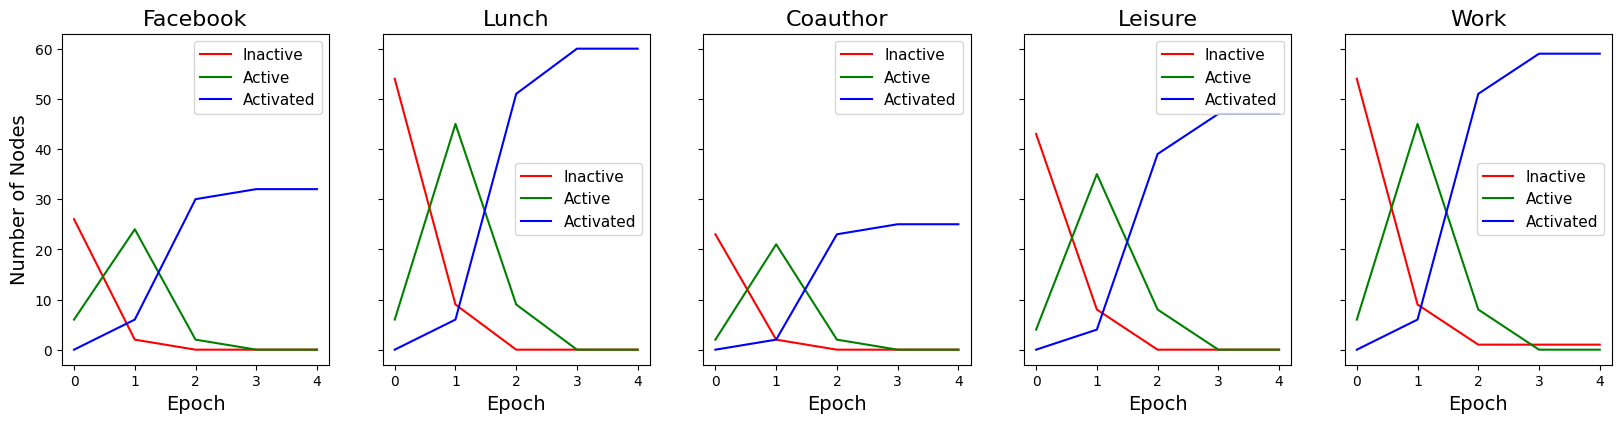

In [21]:
layers = ['facebook', 'lunch', 'coauthor', 'leisure', 'work']
statuses = ['0', '1', '-1']
status_labels = {'0': 'Inactive', '1': 'Active', '-1': 'Activated'}  # Mapping from status to label
plot_data = {layer: {status: [] for status in statuses} for layer in layers}

# Populate the plot data
for epoch, record in enumerate(parsed_data):
    for layer in layers:
        layer_data = dict(record.get(layer, []))
        for status in statuses:
            plot_data[layer][status].append(layer_data.get(status, 0))

# Generate plots
fig, axes = plt.subplots(1, len(layers), figsize=(20, 4.3), sharey=True)

for ax, layer in zip(axes, layers):
    for status, color in zip(statuses, ['r', 'g', 'b']):
        label = status_labels[status]  # Get the label from the mapping
        ax.plot(plot_data[layer][status], color=color, label=label)  # Use the label in the plot
    ax.set_title(layer.capitalize(), fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.legend(fontsize=11)

axes[0].set_ylabel('Number of Nodes', fontsize=14)
plt.savefig(f"{out_dir}/spreading.pdf", format="pdf")
plt.show()